# Orchestrate a Workplan (multiple blueprints) with C-star CLI

This example demonstrates how to launch a workplan in C-Star. A workplan can call any number of jobs (e.g. ROMS-MARBL blueprints). These jobs can depend on a previous job to finish before beginning.

The jobs in this workplan run regional ocean model simulations, including biogeochemical processes, defined by ROMS-MARBL blueprints. You may want to refer to the [Terminology and Concepts page](../terminology.rst) for a broader overview of what a workplan is and how it fits into the bigger picture.

## Prerequisities

If you already ran the [blueprint tutorial](./tutorial_bp.ipynb), you are set up and ready to go! If not, see the Prerequisites section of that notebook.

From your activated `cstar_env` conda environment, you can launch this notebook with `jupyter lab docs/tutorials/tutorial_wp.ipynb`

<div class="alert alert-info">

Note

This short example is runnable on a MacOS laptop with the default C-Star configuration settings. If you run this example or another use case on an HPC, please visit the  [configuration](../configuration.rst) to learn how to integrate C-Star with SLURM and configure other important behaviors.
</div>

<div class="alert alert-info">

Note

`C-Star` is intended to be run as a command line utility. We have formulated this tutorial as a Jupyter Notebook to easily step through commands and see results as they run, using the `!` Jupyter directive to run terminal and CLI commands. All of these commands could be similarly run from a terminal shell without the `!`.
</div>

For this demo, we will utilize two pre-made ROMS-MARBL blueprints and their associated data. These data reside in our [examples repository](https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example) and are also explored in more detail in the [blueprint tutorial](./tutorial_bp.ipynb).


## Overview of the workplan

### Define the workplan

We can print the content of the workplan with `cat workplan_laptop_example.yaml`, and cross-reference the attributes with those in the [workplans page](../workplans.rst).

**Print out the blueprint contents:**

In [1]:
!cat workplan_laptop_example.yaml

name: example_workplan
description: Runs a Wales model, then a WIO model, all on your laptop!
state: draft

steps:
  - name: wales
    application: roms_marbl
    blueprint: ./wales_toy_blueprint.yaml
    
  - name: wio
    application: roms_marbl
    blueprint: ./wio_toy_blueprint.yaml
    depends_on:
      - wales




The workplan itself has a `name`, `description`, and a `state.` The `state` can either be `draft` or `validated`; in future versions of C-Star, `validated` workplans will perform additional integrity checks to ensure reproducibility and autidability. `draft` workplans are intended for rapid iteration and quick sharing of workflows between researchers.

Below the workplan attributes, you can define any number of `steps`. Each `step` has its own name, the `application` that will be run, and the `blueprint` containing instructions for that application. Please consult the [Terminology and Concepts page](../terminology.rst) and [workplans page](../workplans.rst) for more details.

This workplan runs the ROMS-MARBL application for two different blueprints pointing to two different domains: Wales and WIO (Western Indian Ocean).

### Job dependence

Note how the `wio` job has a dependence on the `wales` job. The `depends_on` parameter may be used when the results of one simulation (job 1) are necessary to start the following similution (job 2) (e.g. job 2 input files point to the output files from job 1). For our case, we are telling `C-Star` that the `wales` job must finish before the `wio` job can start. Our two jobs are two separate domains that depend on separate files, so a dependence is not necessary here; it is just for purpose of demonstration.\

Any steps without dependencies, or whose dependencies are completed successfully, may be run concurrently. This is less useful on a laptop, but much more helpful on a HPC.

<div class="alert alert-info">

Note

The laptop-based orchestrator utilizes basic processes and has limited functionality compared to the full orchestration that will occur on HPCs (or in the future, on cloud services). For example, on HPCs with SLURM, we submit all of the simulation work as separate SLURM jobs, utilizing SLURM's dependency management and queueing as needed.

</div>

### Validating workplan syntax

Similar to blueprints, we can validate that there are no errors in the workplan syntax before running it:

In [2]:
!cstar workplan check workplan_laptop_example.yaml

The workplan is valid


## Running the workplan

### Run IDs
An important concept to introduce before running our workplan is the **run id**. A run id is a unique identifier (chosen by you on the command line) for *this* execution of your workplan. The run id is used to:

- locate output data generated by a workplan
- check the status of a previously submitted workplan (e.g. for long-running HPC simulations)
- re-start a workplan that has failed or been cancelled

### Directory structure

The location of C-Star-orchestrated application outputs can be set with the `CSTAR_DATA_HOME` environment variable, otherwise it will default to the XDG-compliant location `~/.local/share`. On HPCs, C-Star will attempt to locate and set the default to the user's "scratch" directory based on common HPC environment variables, as scratch directories often have higher I/O speeds that can impact overall model runtime.

Here, we'll set our data directory to be in a non-hidden location for easy cleanup later.

In [3]:
!cstar blueprint check wio_toy_blueprint.yaml

The blueprint is valid


In [4]:
%env CSTAR_DATA_HOME=~/cstar/orchestrated/

env: CSTAR_DATA_HOME=~/cstar/orchestrated/


C-Star will automatically create subdirectories underneath this location to organize the inputs and outputs based on your run-id and the `step` names within your workplan.

### Run the workplan

Now we'll execute our workplan and watch the two simulations run back-to-back.

<div class="alert alert-info">

Note

If you run this cell more than once with the same run ID, you'll receive an error noting that outputs already exist. This is intended, to protect against accidentally overwriting important data, or accidentally working in a directory with incomplete data. You can either set a new Run ID, or use the CSTAR_CLOBBER_WORKING_DIR=1 environment variable to automatically clear any old data.
</div>

In [5]:
!cstar workplan run workplan_laptop_example.yaml --run-id my-first-run

2026-02-24 23:16:13,817 [INFO] - dag_runner.py:179 - A time-split workplan will be executed.
Local run of `roms_marbl` created pid: 27197
2026-02-24 23:16:13,835 [INFO] - orchestration.py:600 - Launched step: wales
2026-02-24 23:16:29,887 [INFO] - simulation.py:1220 - 🛠️ Configuring ROMSSimulation
2026-02-24 23:16:29,887 [INFO] - simulation.py:1223 - 🔧 Setting up ROMSExternalCodeBase...
2026-02-24 23:16:38,848 [INFO] - simulation.py:1223 - 🔧 Setting up MARBLExternalCodeBase...
2026-02-24 23:16:52,444 [INFO] - simulation.py:1237 - 📦 Fetching compile-time code...
2026-02-24 23:16:53,098 [INFO] - simulation.py:1242 - 📦 Fetching runtime code... 
2026-02-24 23:16:53,393 [INFO] - simulation.py:1247 - 📦 Fetching input datasets...
2026-02-24 23:17:06,837 [INFO] - input_dataset.py:225 - Partitioning /Users/eilerman/cstar/orchestrated/my-first-run/tasks/wales/input/input_datasets/roms_grd.nc into (3,3)
2026-02-24 23:17:07,232 [INFO] - input_dataset.py:225 - Partitioning /Users/eilerman/cstar/orc

## Simulation results

Here we can see the final joined output files for each of our two simulations, located under the home directory we specified:

In [6]:
!find ~/cstar/orchestrated/ | grep joined_output

/Users/eilerman/cstar/orchestrated/my-first-run/tasks/wales/joined_output
/Users/eilerman/cstar/orchestrated/my-first-run/tasks/wales/joined_output/output_bgc.20120101120000.nc
/Users/eilerman/cstar/orchestrated/my-first-run/tasks/wales/joined_output/output_bgc_dia.20120101120000.nc
/Users/eilerman/cstar/orchestrated/my-first-run/tasks/wales/joined_output/output_his.20120101120000.nc
/Users/eilerman/cstar/orchestrated/my-first-run/tasks/wio/joined_output
/Users/eilerman/cstar/orchestrated/my-first-run/tasks/wio/joined_output/output_bgc.20120101000000.nc
/Users/eilerman/cstar/orchestrated/my-first-run/tasks/wio/joined_output/output_bgc_dia.20120101000000.nc
/Users/eilerman/cstar/orchestrated/my-first-run/tasks/wio/joined_output/output_his.20120101000000.nc


The inputs and code used for each simulation are also stored alongside the outputs, in the same structure as an individual blueprint run.

### Example visualization

As before, we can use [ROMS-Tools](https://roms-tools.readthedocs.io/en/latest/plotting_roms_output.html#) to examine our model output. This time, let's look at some BGC data from the Wales domain.


/Users/eilerman/miniconda3/envs/cstar_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


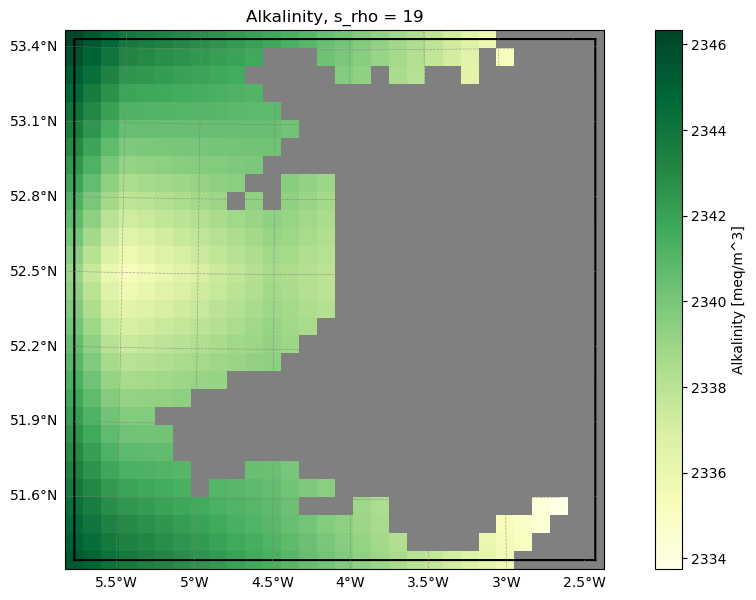

In [7]:
from roms_tools import Grid, ROMSOutput
grid = Grid.from_file("~/cstar/orchestrated/my-first-run/tasks/wales/input/input_datasets/roms_grd.nc")
roms_output = ROMSOutput(
    grid=grid,
    path=[
        "~/cstar/orchestrated/my-first-run/tasks/wales/joined_output/output_bgc.20120101120000.nc",
    ])
roms_output.plot("ALK", time=0, s=-1)
